## Machine Learning: bikeshare data for Capstone 1

Let's start by adding the rest of 2016 data.

As a reminder, the data can be found here, https://s3.amazonaws.com/capitalbikeshare-data/index.html.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

Q1 = pd.read_csv('../CapstoneDrafts/data/2016Q1-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q2 = pd.read_csv('../CapstoneDrafts/data/2016Q2-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q3 = pd.read_csv('../CapstoneDrafts/data/2016Q3-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q4 = pd.read_csv('../CapstoneDrafts/data/2016Q4-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])

In [30]:
Q2.describe() # looks like Q2-4 are in seconds, not milliseconds?

,duration,startlocID,endlocID
count,942333.000000,942333.000000,942333.000000
mean,1222.577555,31306.113708,31307.143061
std,2818.195015,207.970587,204.852343
min,60.000000,31000.000000,31000.000000
25%,419.000000,31203.000000,31205.000000
50%,719.000000,31247.000000,31247.000000
75%,1216.000000,31401.000000,31400.000000
max,86357.000000,32056.000000,32056.000000


In [31]:
Q3.describe()

,duration,startlocID,endlocID
count,1.068194e+06,1.068194e+06,1.068194e+06
mean,1.247531e+03,3.130839e+04,3.130895e+04
std,2.575945e+03,2.081534e+02,2.050651e+02
min,6.000000e+01,3.100000e+04,3.100000e+04
25%,4.330000e+02,3.120400e+04,3.120900e+04
50%,7.420000e+02,3.124900e+04,3.124900e+04
75%,1.265000e+03,3.140000e+04,3.131400e+04
max,8.634000e+04,3.205600e+04,3.205600e+04


In [32]:
Q1.describe()

,duration,startlocID,endlocID
count,5.523990e+05,552399.000000,552399.000000
mean,9.933718e+05,31306.364765,31307.738463
std,2.073981e+06,206.645237,203.722765
min,6.002500e+04,31000.000000,31000.000000
25%,3.715635e+05,31202.000000,31204.000000
50%,6.220460e+05,31246.000000,31246.000000
75%,1.048232e+06,31408.000000,31405.000000
max,8.630620e+07,32053.000000,32053.000000


In [24]:
bike2016 = Q1.append([Q2,Q3,Q4])
bike2016.duration = bike2016.duration * 1.66667e-5
bike2016.head()

,duration,enddate,startlocID,startloc,endlocID,endloc,bikeID,memtype
2016-03-31 23:59:00,5.021593,4/1/2016 0:04,31280,11th & S St NW,31506,1st & Rhode Island Ave NW,W00022,Registered
2016-03-31 23:59:00,9.298135,4/1/2016 0:08,31275,New Hampshire Ave & 24th St NW,31114,18th St & Wyoming Ave NW,W01294,Registered
2016-03-31 23:59:00,9.265752,4/1/2016 0:08,31101,14th & V St NW,31221,18th & M St NW,W01416,Registered
2016-03-31 23:57:00,12.781959,4/1/2016 0:09,31226,34th St & Wisconsin Ave NW,31214,17th & Corcoran St NW,W01090,Registered
2016-03-31 23:57:00,2.327605,3/31/2016 23:59,31011,23rd & Crystal Dr,31009,27th & Crystal Dr,W21934,Registered


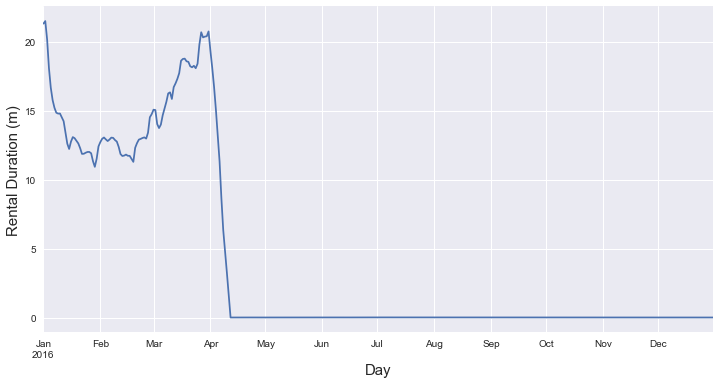

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12,6)
duration = bike2016['duration']
smoothed = duration.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothed.plot(ax=ax)
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Rental Duration (m)',fontsize=15)

Are there different durations for registered versus casual members?

In [6]:
durationReg = bikeshare['duration'][bikeshare['memtype']=='Registered']
durationCas = bikeshare['duration'][bikeshare['memtype']=='Casual']

smoothedReg = durationReg.resample('D').mean().rolling(window=8, min_periods=1).mean()
smoothedCas = durationCas.resample('D').mean().rolling(window=8, min_periods=1).mean()

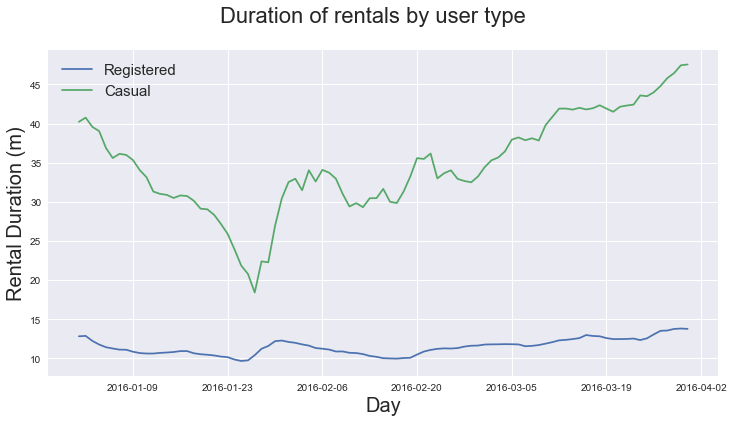

In [7]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,6)
ax.plot(smoothedReg, label='Registered')
ax.plot(smoothedCas, label='Casual')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Rental Duration (m)',fontsize=20)
fig.suptitle('Duration of rentals by user type', fontsize=22)
ax.legend(fontsize=15)
plt.savefig('bike_rolling_type',bbox_inches='tight',dpi=300)

In [1]:
bikeshare['startdate'] = bikeshare.index
bikeshare['startweekday'] = bikeshare['startdate'].apply(lambda d: d.weekday())

NameError: name 'bikeshare' is not defined

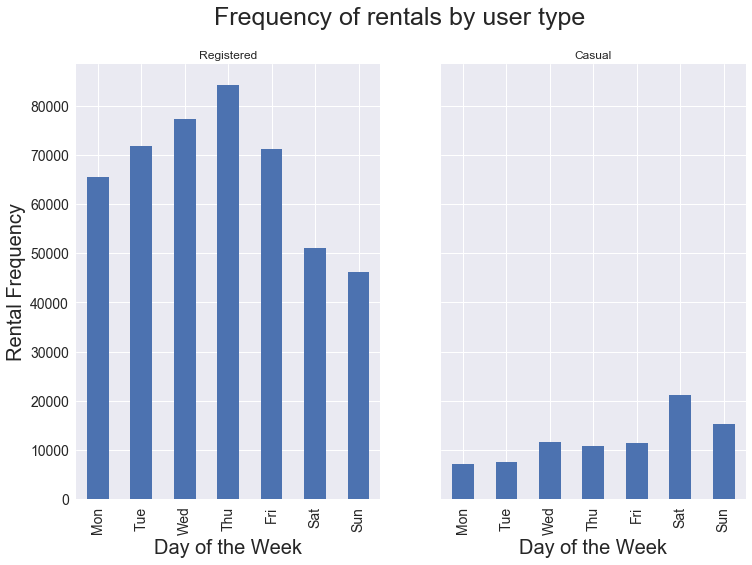

In [9]:
FreqReg=bikeshare['startweekday'][bikeshare['memtype']=='Registered'].value_counts().sort_index()
FreqCas=bikeshare['startweekday'][bikeshare['memtype']=='Casual'].value_counts().sort_index()
ticks=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] 
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12,8)
FreqReg.plot(kind='bar', ax=axes[0],title='Registered',fontsize=14)
FreqCas.plot(kind='bar', ax=axes[1],title='Casual',fontsize=14)
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
fig.suptitle('Frequency of rentals by user type', fontsize=25)
axes[0].set_xlabel('Day of the Week',fontsize=20)
axes[0].set_ylabel('Rental Frequency',fontsize=20)
axes[1].set_xlabel('Day of the Week',fontsize=20)
plt.savefig('bike_histo_type',bbox='tight',dpi=300)

## Next steps:

To move this story forward, we can ask some questions, such as:
1. Can we predict user type by the bike ride duration?
2. Can we predict user type by the day of the week?
3. Compare this winter/spring data to summer or fall data - do the answers to the above questions change?